## Import Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Download the Data

In [0]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)
train_images = mnist.train.images
test_images = mnist.test.images

## Helper Functions

Plot the original and the reconstructed image

In [0]:
def plot_images(original, reconstructed):
  
  fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(12,4))
  
  for images, axes in zip([original, reconstructed], axes):
    for image, ax in zip(images, axes):
      ax.imshow(image.reshape(28,28), cmap="Greys_r")
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
  fig.tight_layout(pad=0.1)

## Define the placeholders

In [0]:
def placeholders(image_size, n_channels ):
  inputs = tf.placeholder(dtype=tf.float32, shape=[None, image_size, image_size,n_channels], name='inputs')
  targets = tf.placeholder(dtype=tf.float32, shape=[None, image_size, image_size, n_channels], name='targets')
  return inputs, targets

## Define the model

In [0]:
def encoder_decoder_network(X):
  
  #ENCODER NETOWRK
  
  # X's shape - 28*28*1
  W1 = tf.get_variable("W1", shape=[3,3,1,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  # 28*28*16 
  conv1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
  relu1 = tf.nn.relu(conv1)
  #14*14*16
  pool1 = tf.nn.max_pool(relu1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
  
  #14*14*8
  W2 = tf.get_variable("W2", shape=[3,3,16,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv2 = tf.nn.conv2d(pool1, W2, strides=[1,1,1,1], padding='SAME')
  relu2 = tf.nn.relu(conv2)
  #7*7*8
  pool2 = tf.nn.max_pool(relu2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
  #7*7*8
  W3 = tf.get_variable("W3", shape=[3,3,8,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv3 = tf.nn.conv2d(pool2, W3, strides=[1,1,1,1], padding='SAME')
  relu3 = tf.nn.relu(conv3)
  #4*4*8
  pool3 = tf.nn.max_pool(relu3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
  
  encoded = pool3
  
  # the image is now 4*4*8 
  
  # Decoder network 
  
  
  upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
  #7*7*8
  W4 = tf.get_variable("W4", shape=[3,3,8,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv4 = tf.nn.conv2d(upsample1, W4, strides=[1,1,1,1], padding='SAME')
  relu4 = tf.nn.relu(conv4)
  
  upsample2 = tf.image.resize_nearest_neighbor(relu4, (14,14))
  # 14*14*8
  W5 = tf.get_variable("W5", shape=[3,3,8,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv5 = tf.nn.conv2d(upsample2, W5, strides=[1,1,1,1], padding='SAME')
  relu5 = tf.nn.relu(conv5)
  
  # 28*28*8
  upsample3 = tf.image.resize_nearest_neighbor(relu5, (28,28))
  
  W6 = tf.get_variable("W6", shape=[3,3,8,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv6 = tf.nn.conv2d(upsample3, W6, strides=[1,1,1,1], padding='SAME')
  relu6 = tf.nn.relu(conv6)
  
  W7 = tf.get_variable("W7", shape=[3,3,16,1], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  conv7 = tf.nn.conv2d(relu6, W7, strides=[1,1,1,1], padding='SAME')
  
  logits = conv7
  
  decoded = tf.nn.sigmoid(logits)
  
  return encoded, decoded, logits

## Define the training operations

In [0]:
def train_operations(logits, targets, learning_rate):
  loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=targets))
  training_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
  
  return loss, training_op
  

## Train the model

In [0]:
def train_model(epochs, image_size, n_channels, batch_size, learning_rate):
  
  tf.reset_default_graph()
  inputs, targets = placeholders(image_size, n_channels)
  encoded, decoded, logits = encoder_decoder_network(inputs)
  loss, training_op = train_operations(logits, targets, learning_rate)
  
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
      epoch_loss = 0
      for batch in range(mnist.train.num_examples//batch_size):
        data = mnist.train.next_batch(batch_size)
        images = data[0].reshape(-1, image_size,image_size,n_channels)
        batch_loss, _ = sess.run([loss, training_op], feed_dict = {inputs:images, targets:images})
        epoch_loss += batch_loss
      print("Epoch {}/{}: Loss is {:.3f}".format(epoch+1, epochs, epoch_loss))
    print("Training over\n")
    
    print("Reconstructing test images from encoded images")


    test_images = mnist.test.images[:10]
    test_images = test_images.reshape(-1, image_size, image_size, n_channels)
    reconstructed = sess.run(decoded, feed_dict = {inputs:test_images, targets:test_images})
    plot_images(test_images, reconstructed)

## Define the model parameters

In [0]:
epochs = 20
batch_size = 200
image_size = 28 
n_channels = 1
learning_rate = 0.001


## Run the model

W0622 21:29:21.782744 140662642526080 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20: Loss is 70.720
Epoch 2/20: Loss is 42.294
Epoch 3/20: Loss is 37.771
Epoch 4/20: Loss is 35.435
Epoch 5/20: Loss is 33.994
Epoch 6/20: Loss is 33.090
Epoch 7/20: Loss is 32.429
Epoch 8/20: Loss is 31.904
Epoch 9/20: Loss is 31.442
Epoch 10/20: Loss is 31.063
Epoch 11/20: Loss is 30.731
Epoch 12/20: Loss is 30.437
Epoch 13/20: Loss is 30.185
Epoch 14/20: Loss is 29.978
Epoch 15/20: Loss is 29.792
Epoch 16/20: Loss is 29.642
Epoch 17/20: Loss is 29.473
Epoch 18/20: Loss is 29.340
Epoch 19/20: Loss is 29.230
Epoch 20/20: Loss is 29.132
Training over

Reconstructing test images from encoded images


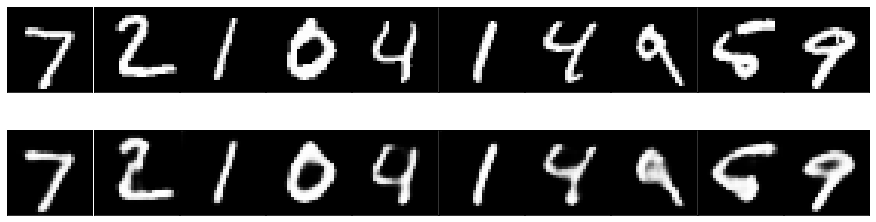

In [9]:
train_model(epochs=epochs, 
            batch_size=batch_size, 
            image_size=image_size, 
            n_channels= n_channels, 
            learning_rate = learning_rate)